# Predicting the sale price of Bulldozers using ML

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition
> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.
## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [4]:
df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [6]:
df.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

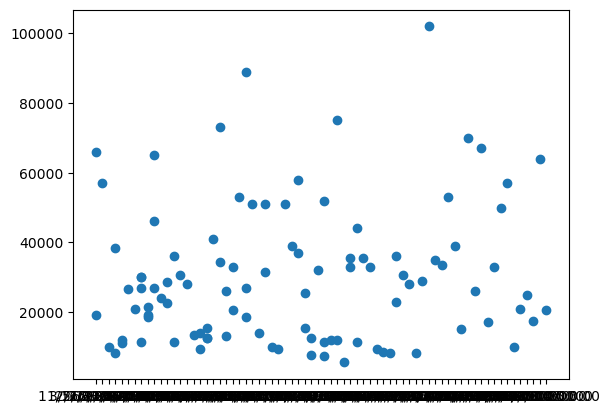

In [7]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:100], df['SalePrice'][:100])

<Axes: ylabel='Frequency'>

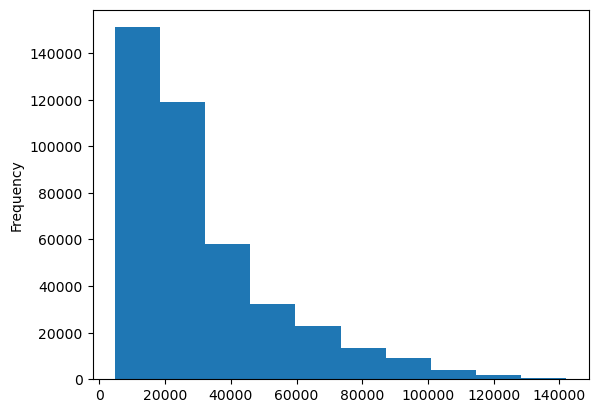

In [8]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [9]:
# Import data again but this time parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [10]:
df.dtypes

SalesID                              int64
SalePrice                          float64
MachineID                            int64
ModelID                              int64
datasource                           int64
auctioneerID                       float64
YearMade                             int64
MachineHoursCurrentMeter           float64
UsageBand                           object
saledate                    datetime64[ns]
fiModelDesc                         object
fiBaseModel                         object
fiSecondaryDesc                     object
fiModelSeries                       object
fiModelDescriptor                   object
ProductSize                         object
fiProductClassDesc                  object
state                               object
ProductGroup                        object
ProductGroupDesc                    object
Drive_System                        object
Enclosure                           object
Forks                               object
Pad_Type   

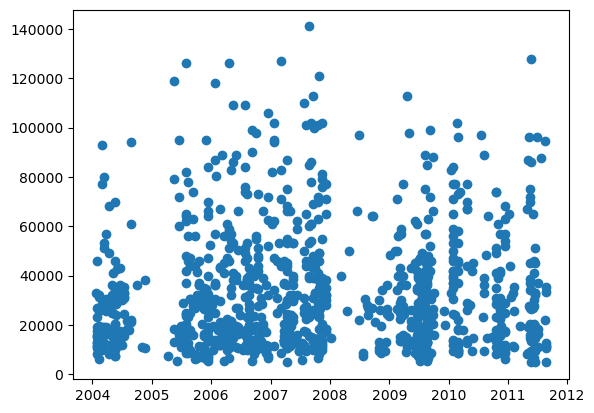

In [11]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

In [12]:
df.head() # you can transpose it to make it easier to view `df.head().T`

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [14]:
# Sort DataFrame in date order
df.sort_values(by='saledate', ascending=True, inplace=True)

In [15]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [16]:
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

## Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [17]:
df_tmp = df.copy()

### Add datetime parameters for saledate column

In [37]:
df_tmp['saleYear'] = df_tmp['saledate'].dt.year
df_tmp['saleMonth'] = df_tmp['saledate'].dt.month
df_tmp['saleDay'] = df_tmp['saledate'].dt.day
df_tmp['saleDayOfWeek'] = df_tmp['saledate'].dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp['saledate'].dt.dayofyear

KeyError: 'saledate'

In [38]:
# Now we've enriched our DataFrame with date time features, we can remove 'saledate'
df_tmp.drop(columns=['saledate'], inplace=True)

KeyError: "['saledate'] not found in axis"

In [20]:
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modeling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [39]:
# Let's build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

ValueError: could not convert string to float: 'Low'

In [42]:
df_tmp["UsageBand"].dtype

dtype('O')

In [43]:
df_tmp.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert String to categories

One way we can turn all of our data into numbers is by converting them into pandas catgories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.api.types.is_object_dtype.html

In [44]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [45]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"].dtype)

True

In [46]:
# Find the columns which contain strings

for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content.dtype):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [47]:
# If you're wondering what df.items() does, here's an example
random_dict = {"key1": "hello", "key2": "world!"}

for key, value in random_dict.items():
    print(f"this is a key: {key}"
          f"this is a value: {value}")

this is a key: key1this is a value: hello
this is a key: key2this is a value: world!


In [48]:
# This will turn all the string value into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content.dtype):
        df_tmp[label] = df_tmp[label].astype("category").cat.as_ordered()

In [49]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [50]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [51]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [52]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data


In [53]:
# Export current tmp dataframe
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv", index=False)

In [54]:
# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv", low_memory=False)
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [55]:
df_tmp.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Filling missing values

### Filling numeric missing values

In [56]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content.dtype):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [57]:
df_tmp.ModelID

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [58]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content.dtype):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [59]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content.dtype):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [60]:
# Demonstrate how median is more robust than mean
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1_000_000_000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [61]:
# Check if there are any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content.dtype):
        if pd.isnull(content).sum():
            print(label)

In [62]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

In [63]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [64]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content.dtype):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [65]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content.dtype):
        # Add a binary column to indicate weather sample had missing values
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        df_tmp[label] = pd.Categorical(content).codes +1

In [66]:
pd.Categorical(df_tmp.state).codes + 1

array([44,  9,  9, ...,  5,  5,  5], dtype=int8)

In [67]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [68]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [69]:
df_tmp.isnull().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all the data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [70]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [71]:
len(df_tmp)

412698

In [72]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1, random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp['SalePrice'])

KeyboardInterrupt: 

In [74]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp['SalePrice'])

IndexError: list index out of range

**Question:** Why does the above metric hold water? (why isn't the metric reliable)

### Splitting data into train/validation sets

In [75]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [76]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [77]:
# Split data into tests and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_train), len(df_val)

(401125, 11573)

In [78]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_val, y_val = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [79]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

### Building an evaluation function

In [91]:
# Create evaluation function (The competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def RMSLE(y_true, y_pred):
    """
    Calculates root mean squared log error between predictions and true labels.
    :param y_true:
    :param y_pred:
    :return:
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_val, val_preds),
              "Training RMSLE": RMSLE(y_train, train_preds),
              "Valid RMSLE": RMSLE(y_val, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_val, val_preds)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [81]:
# # This takes far too long... for experimenting
# %% time
# model = RandomForestRegressor(n_jobs=-1, random_state=42)
#
# model.fit(X_train, y_train)

In [82]:
len(X_train)

401125

In [93]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10_000)

In [94]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: user 12min 50s, sys: 17.2 s, total: 13min 7s
Wall time: 2min 18s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [92]:
show_scores(model) # 10_000 samples

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

In [95]:
show_scores(model) # All samples

{'Training MAE': 1578.2015208725463,
 'Valid MAE': 6120.959637950402,
 'Training RMSLE': 0.08426351714047395,
 'Valid RMSLE': 0.25557446689440955,
 'Training R^2': 0.9875150955953674,
 'Valid R^2': 0.8727175969771312}

### Hyperparameter tuning with RandomizedSearchCV

In [98]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
95 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pac

CPU times: user 14min 54s, sys: 45.2 s, total: 15min 39s
Wall time: 4min 11s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [99]:
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [100]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 5991.15488420062,
 'Valid MAE': 7341.609622127842,
 'Training RMSLE': 0.2732365523269232,
 'Valid RMSLE': 0.29797488780025494,
 'Training R^2': 0.8401959898357005,
 'Valid R^2': 0.8246254421177884}

### Train a model with the best hyperparameters
**Note:** These were found after 100 iterations of `RandomizedSearchCV`

In [101]:
%%time

# Most ideal hypermarkets
ideal_model = RandomForestRegressor(n_jobs=-1,
                                    random_state=42,
                                    n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    max_samples=None)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 2min 10s, sys: 2.76 s, total: 2min 13s
Wall time: 21.9 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [103]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

In [104]:
# Scores for rs_model (only trained on ~10,000 examples)
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

## Make predictions on test data

In [144]:
# Import the test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [145]:
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...


### Preprocessing the data (getting the test data in the same format as our training dataset)

In [146]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    :param df:
    :return:
    """
    df['saleYear'] = df['saledate'].dt.year
    df['saleMonth'] = df['saledate'].dt.month
    df['saleDay'] = df['saledate'].dt.day
    df['saleDayOfWeek'] = df['saledate'].dt.dayofweek
    df['saleDayOfYear'] = df['saledate'].dt.dayofyear

    df.drop("saledate", axis=1, inplace=True)

    # Fill the numeric rows
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content.dtype):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())

            # Filled categorical missing data and turn categories into numbers
        else:
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encode missing categories as -1
            df[label] = pd.Categorical(content)+1
    return df

In [147]:
# process the test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [148]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing


In [149]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [153]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

set()

In [161]:
df_test["auctioneerID_is_missing"] = False
df_test = df_test.reindex(columns=list(X_train.columns))
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [164]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)
test_preds

array([17030.00927386, 14355.53565165, 46623.08774286, ...,
       11964.85073347, 16496.71079281, 27119.99044029])

We've made predictions, but they're not in the same format Kaggle is asking for
https://www.kaggle.com/c/blubook-for-bulldozers/overview/evaluation

In [166]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds.head()

,SalesID,SalesPrice
0,1227829,17030.009274
1,1227844,14355.535652
2,1227847,46623.087743
3,1227848,71680.261335
4,1227863,61762.999424


In [167]:
df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv")

### Feature Importance

Feature importance figure out which different attributes of the data were most important when it comes to predicting the **target variable** (SalePrice).

In [168]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [173]:
# Helper function for plotting features importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns, "feature_importances": importances})
          .sort_values(by="feature_importances", ascending=False)).reset_index(drop=True)

    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:20], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Importance")
    ax.invert_yaxis()

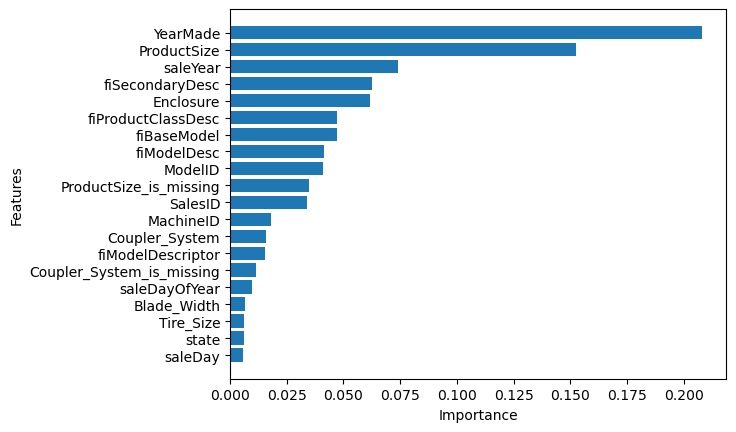

In [174]:
plot_features(X_train.columns, ideal_model.feature_importances_, n=20)

In [175]:
df["Enclosure"].value_counts()

Enclosure
OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: count, dtype: int64

**Question to finish:** Why might knowing the feature importance of a trained machine learning model be helpful?

**Final challenge/extension:** What other machine learning models could you try on our dataset? Hint: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html check out the regression section of this map, or try to look at something like CatBoost.ai or XGBooost.ai.